In [1]:
using Plots
using LinearAlgebra
using JLD2

function read_eigenresults(number::Integer)
    output_file = "Sparsity_test/EV_matrix2_$(number).jld2"
    println("Reading eigenvalues from $output_file")
    data = jldopen(output_file, "r")
    eigenvalues = data["eigenvalues"]
    close(data)
    return sort(eigenvalues)
end

ev = abs.(read_eigenresults(1))

# plot(ev, seriestype = :scatter, title = "Eigenvalues from Sparsity_test", xlabel = "Index", ylabel = "Eigenvalue (log scale)")

Reading eigenvalues from Sparsity_test/EV_matrix2_1.jld2


30000-element Vector{Float64}:
  0.24055644920770655
  0.08071865132201758
  0.06362222905102771
  0.05047290883383143
  0.04801441030548542
  0.04694293526501747
  0.04607717659602084
  0.044308031189789376
  0.0432757261524446
  0.038421676762749685
  ⋮
  0.16642795020036
  0.1745062304454862
  0.19315063430147666
  0.20847222908711316
  0.2360158003593052
  0.26174697815192355
  0.2931344005719308
  0.400050100958022
 16.35710717550118

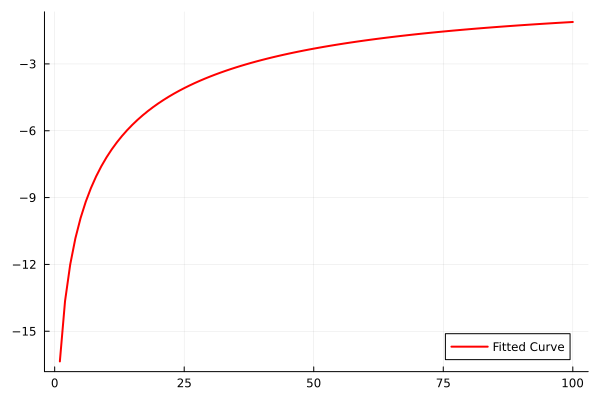

In [4]:
function new_curve(x, gamma, delta, epsilon)
    return - gamma .* exp.(- delta .* x.^ epsilon)
end

a = 31.2458198825
b = 0.6473512253
c = 0.3556968463

x_data = collect(1:100)
y_data = new_curve(x_data, a, b, c)

plot(x_data, y_data, label = "Fitted Curve", lw = 2, lc = :red)

In [8]:
using LinearAlgebra
using JLD2

function read_eigenresults(molecule::String)
    output_file = "Eigenvalues_folder/eigenres_" * molecule * "_RNDbasis1.jld2"
    println("Reading eigenvalues from $output_file")
    data = jldopen(output_file, "r")
    eigenvalues = data["eigenvalues"]
    close(data)
    return sort(eigenvalues)
end

molecules = ["H2", "formaldehyde", "uracil"]
N_occ = [1, 6, 21]
for (i, molecule) in enumerate(molecules)
    eigenvalues = read_eigenresults(molecule)
    number = Int(100 * N_occ[i])
    println("Eigenvalue : ", eigenvalues[number])
end

Reading eigenvalues from Eigenvalues_folder/eigenres_H2_RNDbasis1.jld2
Eigenvalue : -0.02884227021354573
Reading eigenvalues from Eigenvalues_folder/eigenres_formaldehyde_RNDbasis1.jld2
Eigenvalue : -0.005902029073540208
Reading eigenvalues from Eigenvalues_folder/eigenres_uracil_RNDbasis1.jld2
Eigenvalue : -0.004051281674225675


In [9]:
using Preconditioners
using SparseArrays
using IterativeSolvers
using LinearAlgebra


A = sprand(1000, 1000, 0.01)
A = A + A' + 30I

# Diagonal preconditioner
pd = DiagonalPreconditioner(A)

# Incomplete Cholesky preconditioner with cut-off level 2
pc = CholeskyPreconditioner(A, 2)

prec = [pd, pc]
# Solve the system of equations
b = A*ones(1000)
for p in prec
    x, ch = cg(A, b, Pl=p, log=true)
    list = split(string(ch))
    niter = list[3]
    niter_int = parse(Int, niter)
    println("list of stats: ", ch)
    println("number of iterations: ", niter)
end

for p in prec
    x, ch = cg(A, b, Pl=p, log=true)
    msg = string(ch)
    m = match(r"(\d+)\s+iterations", msg)
    if m !== nothing
        niter = parse(Int, m.captures[1])
        println("status msg: ", msg)
        println("number of iterations: ", niter)
        println("type of niter: ", typeof(niter))
    else
        println("No iteration number found in message: ", msg)
    end
end

list of stats: Converged after 8 iterations.
number of iterations: 8
list of stats: Converged after 4 iterations.
number of iterations: 4
status msg: Converged after 8 iterations.
number of iterations: 8
type of niter: Int64
status msg: Converged after 4 iterations.
number of iterations: 4
type of niter: Int64


In [10]:
using LinearMaps, IterativeSolvers, LinearAlgebra, JLD2

function read_eigenresults(number::Int)
    output_file = "test/Eigenvalues_folder/eigenresults_matrix_$(number).jld2"
    println("Reading eigenvalues from $output_file")
    data = jldopen(output_file, "r")
    eigenvalues = -data["Σexact"]
    close(data)
    return sort(eigenvalues)
end

eigenvalues_1 = read_eigenresults(1)
eigenvalues_2 = read_eigenresults(2)
eigenvalues_3 = read_eigenresults(3)
eigenvalues_4 = read_eigenresults(4)
eigenvalues_5 = read_eigenresults(5)
eigenvalues_6 = read_eigenresults(6)

# read first 20 eigenvalues
for i in 1:6
    println("First 20 eigenvalues of matrix $i: ", eval(Symbol("eigenvalues_$i"))[1:20])
end


Reading eigenvalues from test/Eigenvalues_folder/eigenresults_matrix_1.jld2
Reading eigenvalues from test/Eigenvalues_folder/eigenresults_matrix_2.jld2
Reading eigenvalues from test/Eigenvalues_folder/eigenresults_matrix_3.jld2
Reading eigenvalues from test/Eigenvalues_folder/eigenresults_matrix_4.jld2
Reading eigenvalues from test/Eigenvalues_folder/eigenresults_matrix_5.jld2
Reading eigenvalues from test/Eigenvalues_folder/eigenresults_matrix_6.jld2
First 20 eigenvalues of matrix 1: [-23.978377110229157, -19.657075544253022, -17.094688632871684, -15.293640659853793, -13.920120748628545, -12.820159581337812, -11.909846834111327, -11.138381170404044, -10.472712459877043, -9.890125928428331, -9.374396607931594, -8.91347271912299, -8.49825870747107, -8.121661770435725, -7.778045105263762, -7.462941986363561, -7.172618370252416, -6.904094822831796, -6.654794434123425, -6.42259819539194]
First 20 eigenvalues of matrix 2: [-23.978455365167758, -19.657172709731952, -17.094807897576505, -15.2

In [11]:
using LinearMaps, IterativeSolvers, LinearAlgebra

# Dummy FLOP counters
global NFLOPs = 0
count_matmul_flops(args...) = nothing
count_vec_add_flops(args...) = nothing
count_vec_scaling_flops(args...) = nothing

# Your correction_equations_minres function here
function correction_equations_minres(A, U, lambdas, R; tol=1e-1, maxiter=100)
    global NFLOPs
    n, k = size(U)
    S = zeros(eltype(A), n, k)

    for j in 1:k
        λ, r = lambdas[j], R[:, j]

        M_apply = function(x)
            x_perp = x - (U * (U' * x)); 
            tmp = (A * x_perp) - λ * x_perp; 
            res = tmp - (U * (U' * tmp)); 
            return res
        end

        M_op = LinearMap{eltype(A)}(M_apply, n, n; ishermitian=true)

        rhs = r - (U * (U' * r)); 
        rhs = -rhs

        # Call MINRES with logging
        s_j, history = minres(M_op, rhs; reltol=tol, maxiter=maxiter, log=true)

        println("Vector $j: MINRES iterations = ", history.iters)

        s_j = s_j - (U * (U' * s_j)); 
        S[:, j] = s_j
    end
    return S
end

# === Example Problem ===
n = 10
A = Symmetric(randn(n, n))  # symmetric matrix
U = randn(n, 2)             # trial subspace
lambdas = [1.0, 2.0]        # fake Ritz values
R = randn(n, 2)             # fake residuals

S = correction_equations_minres(A, U, lambdas, R; tol=1e-6, maxiter=50)
println("Solution matrix S =")
println(S)


Vector 1: MINRES iterations = 11
Vector 2: MINRES iterations = 11
Solution matrix S =
[0.16502991726152627 -0.08359246137231913; 1.8372303476109682 0.4940175895134289; -0.09601236479458441 0.4105486423542858; -0.38721621575041787 0.09604191941745993; -0.5592493889230832 -0.4957337818627149; -1.3055166518879722 -0.20809622963129007; -0.21457795749776076 0.3172382584204762; 0.8377240576172506 0.3839532453855997; -1.747186101662217 -0.09756858965620735; 0.5106627369629583 0.7488613107413602]


In [12]:
using BenchmarkTools

function algo1(n)
    return sum(1:n)
end

function algo2(n)
    return n * (n + 1) ÷ 2
end

@btime algo1(10^6)
@btime algo2(10^6)


  0.760 ns (0 allocations: 0 bytes)
  0.759 ns (0 allocations: 0 bytes)


500000500000

In [13]:
using BenchmarkTools, Plots

function benchmark_scaling(f, sizes)
    times = Float64[]
    for n in sizes
        t = @belapsed f($n)   # high-precision elapsed time
        push!(times, t)
    end
    return times
end

sizes = 10 .^ (2:6)
times1 = benchmark_scaling(algo1, sizes)
times2 = benchmark_scaling(algo2, sizes)

plot(sizes, times1, label="algo1", xscale=:log10, yscale=:log10, xlabel="Input size n", ylabel="Time (s)")
plot!(sizes, times2, label="algo2")


UndefVarError: UndefVarError: `f` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [14]:
Profile.clear()
@profile algo1(10^6)
using ProfileView   # nice GUI flamegraphs
ProfileView.view()


UndefVarError: UndefVarError: `Profile` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: Profile is loaded but not imported in the active module Main.

In [15]:
using PAPI

PAPI.start_counters(["PAPI_FP_OPS"]) do
    A = rand(1000,1000)
    B = rand(1000,1000)
    C = A * B
end


InitError: InitError: PAPI.PAPIError("Invalid argument")
during initialization of module PAPI

In [16]:
using IterativeSolvers
using LinearAlgebra

# Example system: A * x = b
A = [4.0 1.0;
     1.0 3.0]
b = [1.0, 2.0]

# Solve with GMRES
x, history = gmres(A, b; log=true)

println("Solution x = ", x)
println("Residual norms = ", history.data)

# exact solution
x_exact = A \ b
println("Exact solution x = ", x_exact)

Solution x = [0.09090909090909091, 0.6363636363636362]
Residual norms = Dict{Symbol, Any}(:reltol => 1.4901161193847656e-8, :abstol => 0.0, :resnorm => [0.5423261445466404, 1.0092936587501423e-16])
Exact solution x = [0.09090909090909091, 0.6363636363636364]
